# Tutorial 6 - Soprano for defect calculations


```
      _
    /|_|\   
   / / \ \  
  /_/   \_\  
  \ \   / /  
   \ \_/ /  
    \|_|/  

```
SOPRANO: a Python library for generation, manipulation and analysis of large batches of crystalline structures


*Developed within the CCP-NC project. Copyright STFC 2022*

In [20]:
# Basic imports
import os, sys
sys.path.insert(0, os.path.abspath('..')) # This to add the Soprano path to the PYTHONPATH
                                          # so we can load it without installing it

In [21]:
# Other useful imports

import numpy as np

import ase
from ase import Atoms
from ase.build import bulk, molecule

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1 - Creating defect structures

Soprano has a number of functionalities dedicated to defect calculations. Some of these have been used in work on finding the site in which a muonium pseudo-atom would sit after relaxing inside a crystal ( [L. Liborio, S. Sturniolo et al, *Computational prediction of muon stopping sites using ab initio random structure searching (AIRSS)*](https://aip.scitation.org/doi/abs/10.1063/1.5024450) ).

First, Soprano provides a number of generator functions to create defect structures, either randomly or in a specific way.

`defectGen` allows creating structures with a single added interstitial defect, distributed in a way to fill the empty space in between atoms while never creating any two configurations where the defects are closer than a given radius, using a so-called [Poisson sphere distribution](https://pdfs.semanticscholar.org/26c3/490a9f2bdf8082d351639ff596f000f8e319.pdf). These are good starting points for a random structure search approach.

In [22]:
from soprano.collection import AtomsCollection
from soprano.collection.generate import defectGen, substitutionGen, additionGen

si2 = bulk('Si') # Bulk silicon
dG = defectGen(si2, 'H', poisson_r=0.6, vdw_scale=0.5) # poisson_r controls the minimum distance between two defects, 
                                                       # vdw_scale the one between defects and existing atoms
                                                       # (proportional to both's Van der Waals radius)
dColl = AtomsCollection(dG)

# The smaller poisson_r, the more structures are generated. The process is random and the final number isn't fixed.
print('{0} structures generated'.format(len(dColl)))

98 structures generated


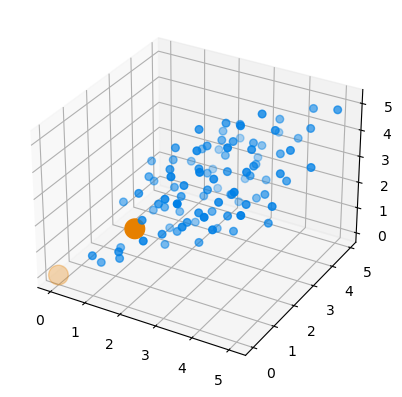

In [23]:
# By default, the defect is placed in position 0 in each new structure
def_pos = dColl.all.get_positions()[:,0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(*def_pos.T, color=(0, 0.5, 0.9), s=30) # Hydrogen defects are blue
ax.scatter3D(*si2.get_positions().T, color=(0.9,0.5,0), s=200) # Silicon atoms are orange
plt.show()

`substitutionGen` allows to simply replace one or more existing atoms with new ones. The replacements can be limited to only a specific selection, and can be accepted or rejected with a test function.

In [24]:
from soprano.properties.linkage import Bonds
from soprano.selection import AtomSelection

# As an example, we generate a molecule of ethyl mercaptan
ethmerc = molecule('CH3CH2SH')
syms = ethmerc.get_chemical_symbols()
bonds, bondmat = Bonds(return_matrix=True)(ethmerc)

# Where are the hydrogens? And the sulfur?
hsel = AtomSelection.from_element(ethmerc, 'H')
ssel = AtomSelection.from_element(ethmerc, 'S')

def isnot_S_bonded(s, subs):
    # Return True only if none of the atoms in subs is bonded to sulfur
    return np.all(bondmat[ssel.indices, list(subs)] == 0)

# Substitute two hydrogens at a time with chlorine, but only if neither is bonded to sulfur
sG = substitutionGen(ethmerc, 'Cl', to_replace=hsel, n=2, accept=isnot_S_bonded)

sColl = AtomsCollection(sG)

print('{0} structures generated'.format(len(sColl)))

10 structures generated


`additionGen` operates similarly, adding one or more atoms of the given species to a certain selection, and picking the direction to add them in a way that it will be as far as possible from existing bonds, again, under verification of an acceptance function if required.

In [25]:
# We try additioning hydrogen to ethylene
eth = molecule('C2H4')

csel = AtomSelection.from_element(eth, 'C')
aG = additionGen(eth, 'H', to_addition=csel, add_r=1.0)

aColl = AtomsCollection(aG)

# Should generate four structures: 2 carbon atoms x 2 possible directions (above and below the plane of the molecule)
print('{0} structures generated'.format(len(aColl)))

4 structures generated


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


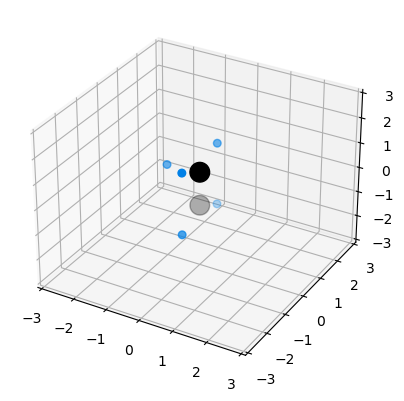

In [26]:
# Plot structure with index s_i
s_i = 0
s = aColl.structures[s_i]

pos = s.get_positions()
csel = AtomSelection.from_element(s, 'C')
hsel = AtomSelection.from_element(s, 'H')


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_zlim(-3,3)

ax.scatter3D(*pos[csel.indices].T, c=(0,0,0), s=200)
ax.scatter3D(*pos[hsel.indices].T, c=(0,0.5,0.9), s=30)

## 2 - Analysing defect structures

A different problem when dealing with the results of random structure searching is how to group together a number of predicted defect positions that might be crystallographically equivalent. In Soprano, this is helped by a clustering gene called `defect_asymmetric_fdist`, for "asymmetric fractional distance". This is a pair gene (it only computes a distance between pairs of structures and only allows for hierarchical clustering), and it computes how close in fractional coordinates two defects can get if all possible symmetry operations that apply to a given pure structure are tried to bring them together. The distance itself has no specific physical meaning as it's in fractional space, but it works well to group the defects together if there's a meaningful structure to begin with. The gene requires having the space group library `spglib` installed.

In [27]:
from scipy.cluster.hierarchy import dendrogram
from soprano.analyse.phylogen import PhylogenCluster, Gene

# Let's create a number of different possible sites in silicon, split in two groups: tetrahedral and bond-centred site,
# but within a number of equivalent coordinates, and with some noise added in.

def_fpos = np.array([
    [0.125]*3,
    [0.125*5, 0.125, 0.125],
    [0.125]*3,
    [0.125*5, 0.125, 0.125],
    [0.5]*3,
    [0.75]*3,
    [0.5]*3,
    [0.75]*3
])

def_fpos += (np.random.random(def_fpos.shape)-0.5)*0.05

defColl = AtomsCollection([Atoms('H', scaled_positions=[fp], cell=si2.get_cell())+si2 for fp in def_fpos])

# Specify that the defect is at index 0, and that the pure structure is si2
dafGene = Gene('defect_asymmetric_fdist', params={'struct': si2, 'index': 0})

defClust = PhylogenCluster(defColl, genes=[dafGene])

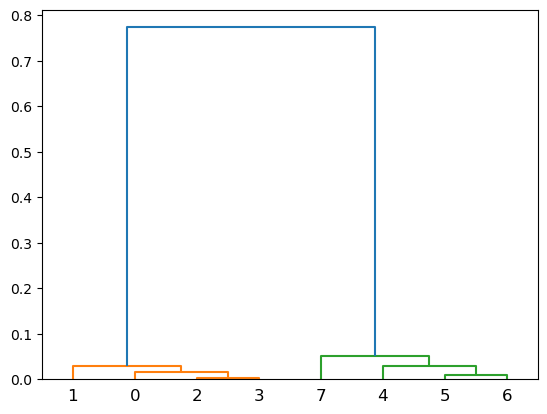

In [28]:
Z = defClust.get_linkage()

fig = plt.figure()
ax = fig.add_subplot(111)

# The structures should be neatly split in two clusters of four
dd = dendrogram(Z, ax=ax)